<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/GAN/GAN_102_DCGAN_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

The notebook enhances GAN 101 by replacing Fully connected layers with Deep Convolution.

Here are the main features of DCGAN

* Use convolutions without any pooling layers
* Use batchnorm in both the generator and the discriminator
* Don't use fully connected hidden layers
* Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
* Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

---

### Task
MNIST Digit generation, build and train a Deep Convolution GAN that can generate hand-written images of digits (0-9).

### Reference
https://nbviewer.jupyter.org/github/sahilkhose/Generative-Adversarial-Networks-GANs-Specialization/blob/main/course1/week2/C1_W2_Assignment.ipynb

## Generator

Generator class. It will take 3 values:

    The noise vector dimension
    The image dimension
    The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). The final layer does not need a normalization or activation function, but does need to be scaled with a sigmoid function.

In [2]:
import torch
from torch import nn

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator

The second component that you need to construct is the discriminator. 

will use 3 layers in your discriminator's neural network.

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training

set your parameters:

* **criterion:** the loss function
* **n_epochs:** the number of times you iterate through the entire dataset when training
* **z_dim:** the dimension of the noise vector
* **display_step:** how often to display/visualize the images
* **batch_size:** the number of images per forward/backward pass
* **lr:** learning rate
* **beta_1, beta_2:** the momentum term
* **device:** the device type, here using a GPU (which runs CUDA), not CPU


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST # Training dataset
from torchvision import transforms

criterion = nn.BCEWithLogitsLoss()
z_dim = 64
batch_size = 128
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


initialize your generator, discriminator, and optimizers.

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
  
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse: MNIST Digits Progression

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show_tensor_images(image_tensor1, image_tensor2, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_real = image_tensor1.detach().cpu().view(-1, *size)
    image_grid_real = make_grid(image_real[:num_images], nrow=5)
    image_grid_real = image_grid_real.permute(1, 2, 0).squeeze()

    image_fake = image_tensor2.detach().cpu().view(-1, *size)
    image_grid_fake = make_grid(image_fake[:num_images], nrow=5)
    image_grid_fake = image_grid_fake.permute(1, 2, 0).squeeze()
    img_sep = torch.ones(image_grid_fake.shape[1], 10 , image_grid_fake.shape[2])
    #print(img_sep)
    image_grid = np.concatenate([image_grid_real, img_sep, image_grid_fake], axis=1)
    plt.imshow(image_grid)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 0.8857934781610959, discriminator loss: 0.583964040458203


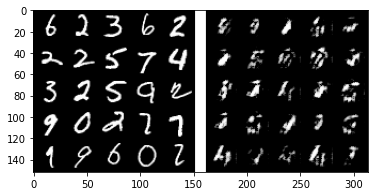

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 0.8969853457808518, discriminator loss: 0.5771432656645774


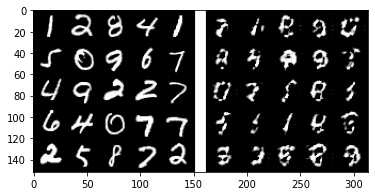

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 0.9547035948932171, discriminator loss: 0.5479661342799675


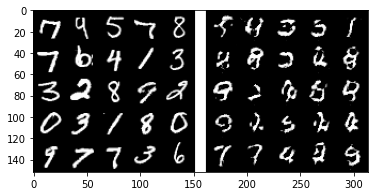

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 0.9214301917850974, discriminator loss: 0.5716064079999926


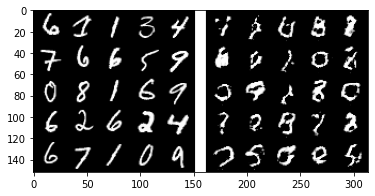

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 0.8698673720359799, discriminator loss: 0.6069303518533706


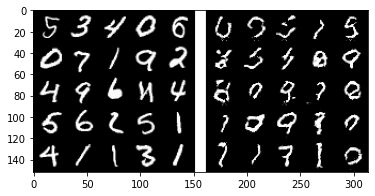

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 0.8766967284232395, discriminator loss: 0.6230434140264995


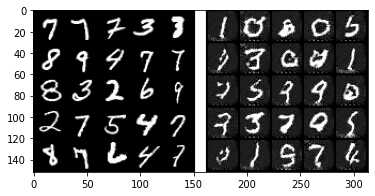

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 0.7808595765233046, discriminator loss: 0.6596046559214593


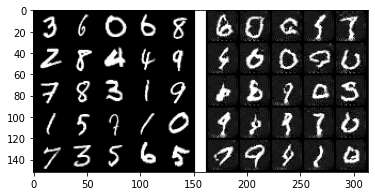

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 0.7738957842290404, discriminator loss: 0.6689811187982553


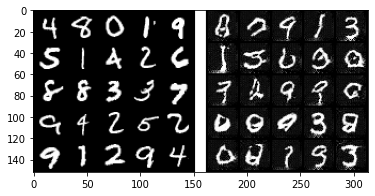

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 0.7544313408732425, discriminator loss: 0.6802623156309122


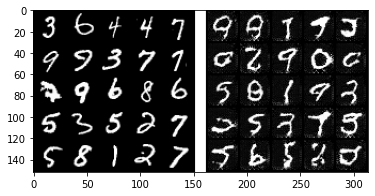

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: 0.7447865814566602, discriminator loss: 0.6875360556244857


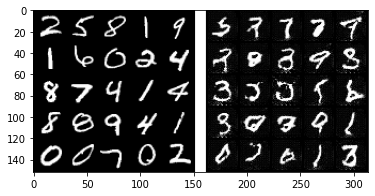

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: 0.7330056025981905, discriminator loss: 0.6900529993772498


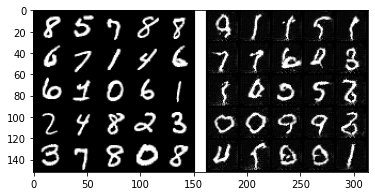

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000: Generator loss: 0.725252100527287, discriminator loss: 0.6954208816885951


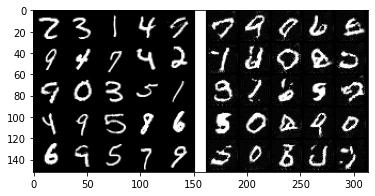

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000: Generator loss: 0.7194711478948602, discriminator loss: 0.697188115894794


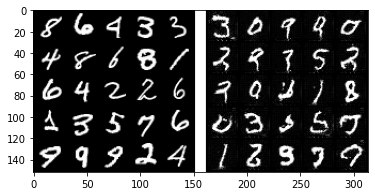

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000: Generator loss: 0.7141561504006395, discriminator loss: 0.6990158399939544


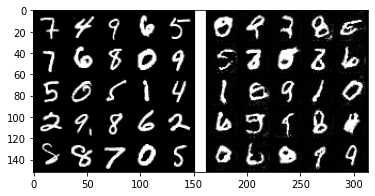

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000: Generator loss: 0.7094013128280642, discriminator loss: 0.7001711112856865


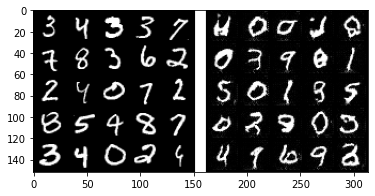

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000: Generator loss: 0.7066777612566925, discriminator loss: 0.6996290311217318


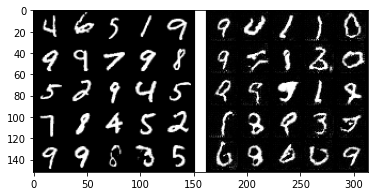

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000: Generator loss: 0.7051080918312073, discriminator loss: 0.69855810290575


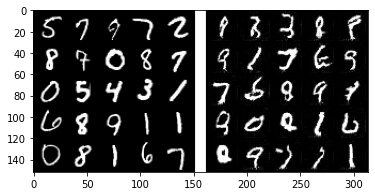

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18000: Generator loss: 0.7054712359905239, discriminator loss: 0.6983812451958661


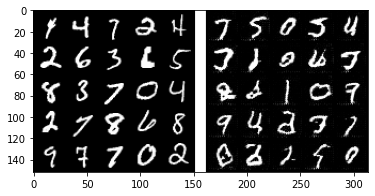

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19000: Generator loss: 0.7032980091571801, discriminator loss: 0.6985670170187955


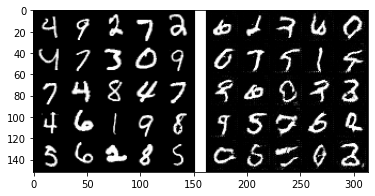

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20000: Generator loss: 0.7022384012937539, discriminator loss: 0.6983838380575176


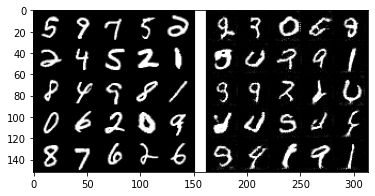

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 21000: Generator loss: 0.701078467607498, discriminator loss: 0.6981966078281402


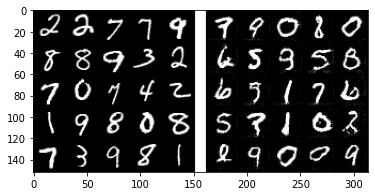

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 22000: Generator loss: 0.6996349956393257, discriminator loss: 0.6981810663342486


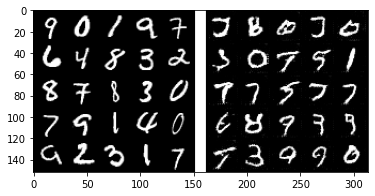

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 23000: Generator loss: 0.698871488809585, discriminator loss: 0.6981943795084946


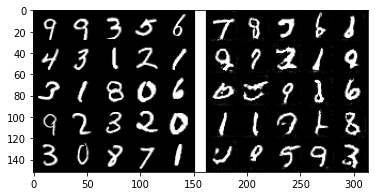

In [11]:
from tqdm.auto import tqdm

n_epochs = 50
display_step = 1000
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0


for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ### Update discriminator ###
        disc_opt.zero_grad()
        
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2    
        disc_loss.backward(retain_graph=True)
        disc_opt.step()


        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()


        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(real, fake)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1